# Running SGP4 to calculate and plot Fermi beta angle

### <span style="color:red; font-family:Georgia;">Robert Cameron, July 2015</span>

Based on the python implementation of SGP4 orbit propagator
available at https://pypi.python.org/pypi/sgp4/

In [100]:
# specify the date range to calculate the beta angle for Fermi
start = "2015-07-01" 
stop = "2016-07-01"

In [101]:
import numpy as np
%pylab inline
rcParams['figure.figsize'] = 12, 8
rcParams['font.size'] = 16
#import sys
#from subprocess import Popen, PIPE, STDOUT
from math import asin
#import operator
#from functools import reduce
sys.path.append('/Users/rc/Documents/GLAST/sgp4-1.4')
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv
from sgp4.ext import jday, invjday, days2mdhms
import datetime as dt     
today = str(dt.date.today())

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [102]:
tle = !tail -2 /Users/rc/Documents/GLAST/FGST-TLE.txt

In [103]:
tle

['1 33053U 08029A   15217.54032653  .00001162  00000-0  52066-4 0  9990',
 '2 33053  25.5834 320.2440 0012528 322.9199  37.0470 15.10036392394132']

In [104]:
satellite = twoline2rv(tle[0], tle[1], wgs84)

In [105]:
(y0,m0,d0) = map(int, start.split("-"))
jd0 = jday(y0,m0,d0,0,0,0)
doy0 = jd0 - jday(y0,1,1,0,0,0)
(y1,m1,d1) = map(int, stop.split("-"))
ndays = int(jday(y1,m1,d1,0,0,0)  - jd0)
(y0, doy0, ndays)

(2015, 181.0, 366)

In [106]:
oformat = "%4d %02d %02d %02d %02d %02d %12.5f %12.6f %12.6f %12.6f %8.3f\n"
fo = open("beta_"+today+".txt", "w")
fdoypl = []
betapl = []
for day in range(ndays):
    for hour in range(24):
# add a small amount to the day number to ensure it is always a fraction of a second past the hour
        dinc = day + hour/24.0 + 1.0e-9
        jd = jd0 + dinc
        fdoy = doy0 + dinc
        (y,mon,d,h,m,s) = invjday(jd)    # need jd for the sun ephemeris
        s = int(s)
        fdoypl.append(fdoy)
        pos, vel = satellite.propagate(y,mon,d,h,m,s)  # this is the key line to specify the date
        pole = np.cross(pos,vel)
        polelen = np.linalg.norm(pole)
# calculate sun coordinates
        n = jd - 2451545.0
        L = (280.460 + 0.9856474 * n) % 360
        g = radians((357.528 + 0.9856003 * n) % 360)
        lamda = radians(L + 1.915 * sin(g) + 0.020 * sin(2*g))
        epsilon = radians(23.439 - 0.0000004 * n)
        Xsun = cos(lamda)
        Ysun = cos(epsilon) * sin(lamda)
        Zsun = sin(epsilon) * sin(lamda)
        dotprod = np.dot([Xsun,Ysun,Zsun], pole)
        beta = degrees(asin(dotprod/polelen))
        betapl.append(beta)
        fo.write(oformat % (y, mon, d, h, m, s, fdoy, pos[0], pos[1], pos[2], beta))

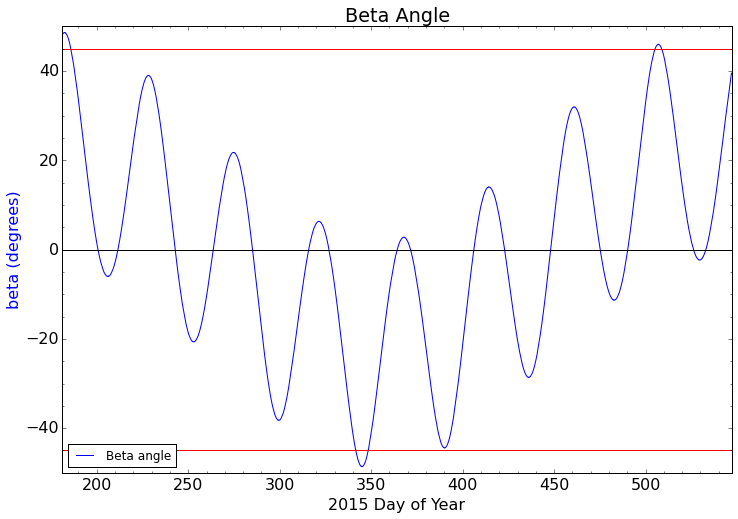

In [107]:
rcParams['figure.figsize'] = 12, 8
pylab.ylim(-50, 50)
pylab.xlim(doy0, doy0+ndays)
pylab.minorticks_on()
pylab.xlabel(str(y0)+' Day of Year')
pylab.ylabel('beta (degrees)', color='b')
pylab.title("Beta Angle")
pylab.plot(fdoypl, betapl, label = 'Beta angle')
pylab.plot([0,doy0+ndays],[0,0],'k')
pylab.plot([0,doy0+ndays],[45,45],'r')
pylab.plot([0,doy0+ndays],[-45,-45],'r')
pylab.legend(loc='best',fontsize=12)
savefig('beta_'+today+'.png')

In [108]:
fo.close()